# 1. Setup and Load Data

### 1.1 Install Dependencies and Setup

In [189]:
!pip install tensorflow opencv-python matplotlib

In [190]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      2.0.0
asttokens                    2.4.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.3.0
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.12.0
debugpy                      1.8.0
decorator                    5.1.1
executing                    2.0.0
flatbuffers                  23.5.26
fonttools                    4.43.0
gast                         0.4.0
google-auth                  2.23.2
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.59.0
h5py                         3.9.0
idna                         3.4
ipykernel                    6.25.2
ipython                      8.16.1
jedi                         0.19.1
jupyter_client               8.3.1
jup

In [1]:
import tensorflow as tf
import os

2023-10-12 11:53:57.646668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 11:53:59.029858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Remove dodgy images

In [3]:
import cv2
import imghdr

/tmp/ipykernel_5576/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### 1.3 Load Data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data',labels='inferred', label_mode='int')

Found 244 files belonging to 3 classes.


In [10]:
data = data.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()
print(batch[1]) #checking if one hot encoded

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


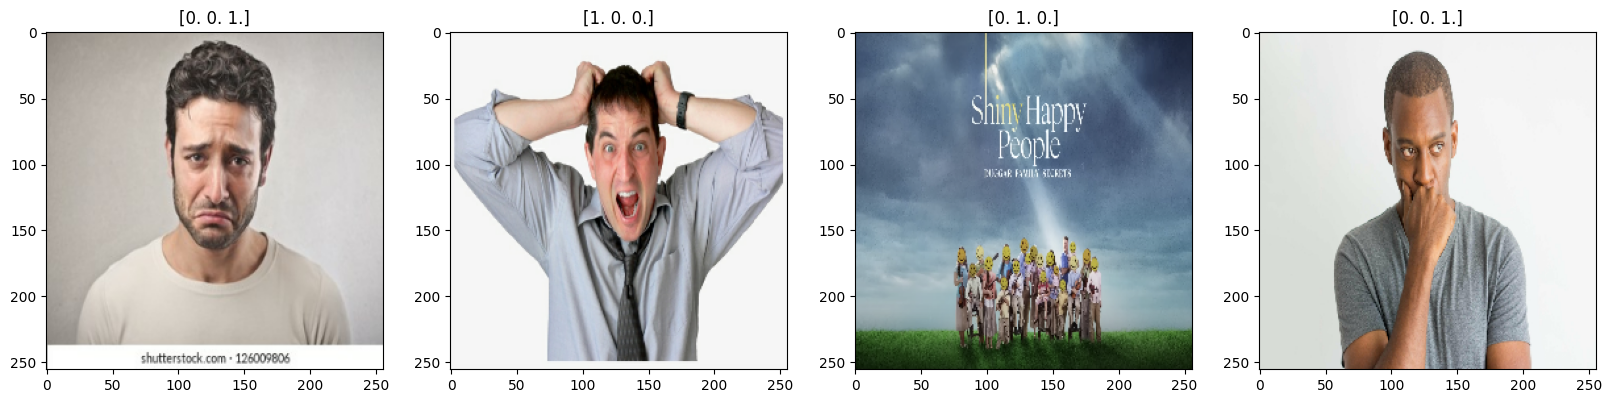

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 2. Preprocess Data

### 2.1 Scale Data

In [14]:
scaled_data = data.map(lambda x,y:(x/255,y))

In [15]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

In [17]:
batch[0].max()

1.0

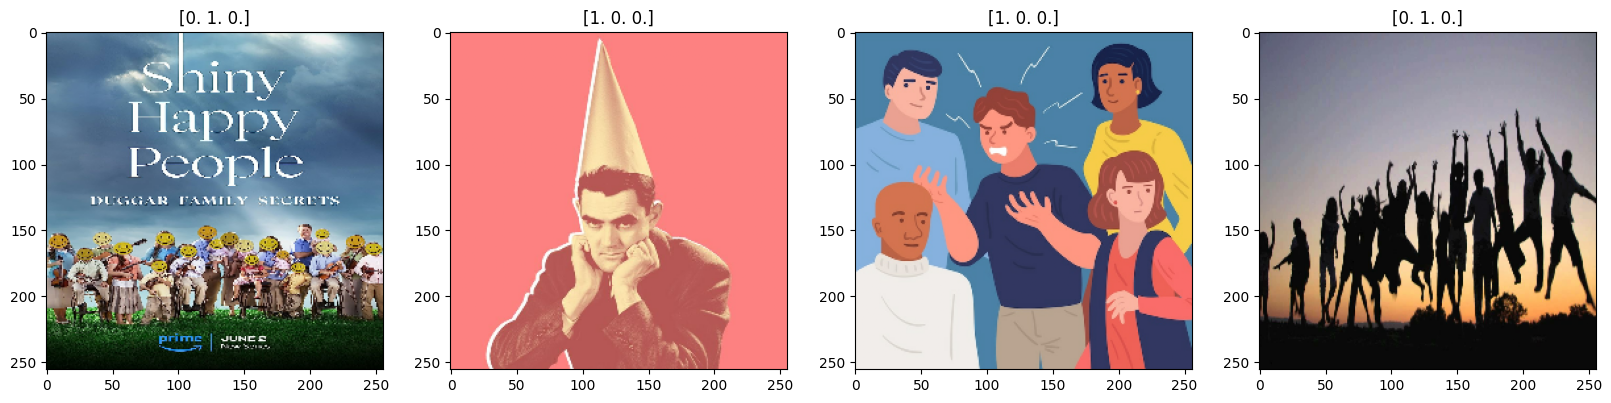

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 2.2 Split Data

In [19]:
len(data)

8

In [22]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+2

In [23]:
train_size + val_size + test_size

8

In [24]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [25]:
len(test)

2

# 3. Deep Model

### 3.1 Building Deep Learning Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### 3.2 Train

In [31]:
logdir = 'logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-10-12 11:56:17.854628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-12 11:56:19.077371: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x710edd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 11:56:19.077440: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 with Max-Q Design, Compute Capability 7.5
2023-10-12 11:56:19.104504: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 11:56:19.403051: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 12s 843ms/step - loss: 422.3358 - accuracy: 0.3000 - val_loss: 52.6913 - val_accuracy: 0.1562
Epoch 2/20
5/5 [==============================] - 4s 601ms/step - loss: 19.0560 - accuracy: 0.3938 - val_loss: 2.1223 - val_accuracy: 0.5938
Epoch 3/20
5/5 [==============================] - 4s 580ms/step - loss: 1.5164 - accuracy: 0.5125 - val_loss: 0.8993 - val_accuracy: 0.5312
Epoch 4/20
5/5 [==============================] - 4s 595ms/step - loss: 0.7785 - accuracy: 0.6938 - val_loss: 0.5492 - val_accuracy: 0.7500
Epoch 5/20
5/5 [==============================] - 4s 599ms/step - loss: 0.5279 - accuracy: 0.8000 - val_loss: 0.3923 - val_accuracy: 0.9062
Epoch 6/20
5/5 [==============================] - 4s 593ms/step - loss: 0.4105 - accuracy: 0.8500 - val_loss: 0.3622 - val_accuracy: 0.9062
Epoch 7/20
5/5 [==============================] - 4s 574ms/step - loss: 0.3304 - accuracy: 0.9062 - val_loss: 0.1873 - val_accuracy: 0.9688
Epoch 8/20
5/5 [==========

### 3.3 Plot Perfomance

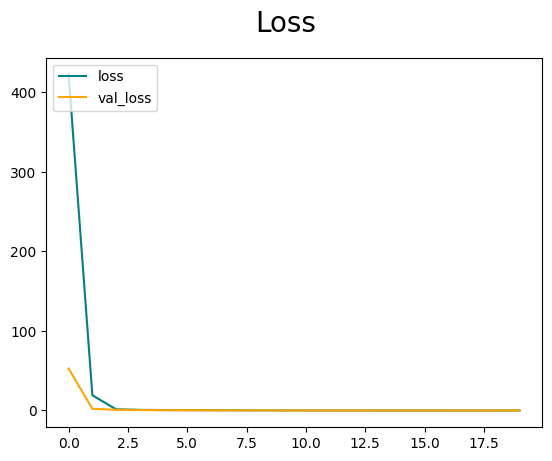

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

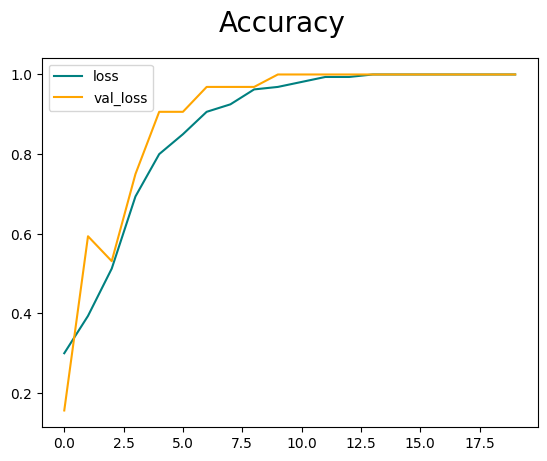

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

### 4.1 Evaluate

In [36]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 563ms/step


In [40]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### 4.2 Test

In [1]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'cv2' is not defined

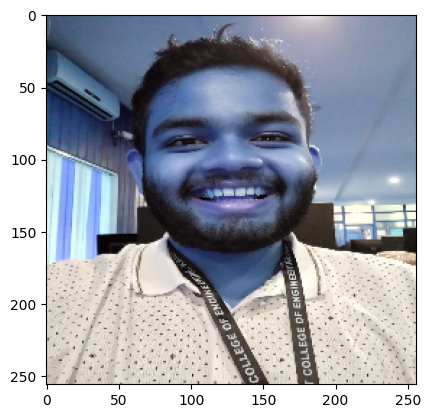

In [62]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [63]:
emotion_labels = ['Angry', 'Happy', 'Sad']

In [64]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 27ms/step


array([[0.33407485, 0.32713348, 0.33879164]], dtype=float32)

In [65]:

predicted_class = np.argmax(yhat)
predicted_emotion = emotion_labels[predicted_class]
print(f'The predicted emotion is: {predicted_emotion}')

The predicted emotion is: Sad


# 5. Save the Model

### 5.1 Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models','imageclassifier.keras'))

In [53]:
new_model = load_model(os.path.join('models','imageclassifier.keras'))

In [54]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 91ms/step


array([[0.35194916, 0.31593108, 0.3321198 ]], dtype=float32)

In [55]:
predicted_class = np.argmax(yhat)
predicted_emotion = emotion_labels[predicted_class]
print(f'The predicted emotion is: {predicted_emotion}')

The predicted emotion is: Angry
